In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py

# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
f = h5py.File("/media/dev/New Volume/projects/RecNN/static_dataset.hdf5", "r")
cuda = torch.device('cuda')
frame_size = 10

In [20]:
class StateRepresentation(nn.Module):
    def __init__(self):
        super(StateRepresentation, self).__init__()
        self.lin = nn.Sequential(
            # 128 - embed size, 1 - rating size
            nn.Linear(frame_size * (128 + 1), 256),
            nn.Tanh(),
        )
        
    def forward(self, state):
        # apply state represemtation module
        state = self.lin(state)
        return state

In [21]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Actor, self).__init__()
        
        self.state_rep = StateRepresentation()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x
    

In [4]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [5]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [6]:
debug_state = None
debug_action = None
debug_gen_action = None


def td3_update(step, batch, gamma = 0.99, noise_std = 0.6,
           noise_clip=1,
           policy_update=3,
           soft_tau=1e-2, debug=False, learn=True):
    
    state, action, reward, next_state, done = batch
    
    if not learn:
        [net.eval() for net in nets]
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(cuda)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise
    
    target_q_value1  = target_value_net1(next_state, next_action)
    target_q_value2  = target_value_net2(next_state, next_action)
    target_q_value   = torch.min(target_q_value1, target_q_value2)
    expected_q_value = reward + (1.0 - done) * gamma * target_q_value
    
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    if debug:
        global debug_state
        global debug_action
        global debug_gen_action
        debug_state = state
        debug_action = action
        debug_gen_action = next_action 

    if not learn:
        # used for testing
        policy_loss = value_net1(state, policy_net(state))
        policy_loss = -policy_loss.mean().log()
        [net.train() for net in nets]
        losses = [value_loss1.item(), value_loss2.item(), policy_loss.item()]
        return losses
    
    value_optimizer1.zero_grad()
    value_loss1.backward()
    value_optimizer1.step()

    value_optimizer2.zero_grad()
    value_loss2.backward()
    value_optimizer2.step()

    if step % policy_update == 0 and learn:
        policy_loss = value_net1(state, policy_net(state))
        policy_loss = -policy_loss.mean().log()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=soft_tau)
        soft_update(value_net2, target_value_net2, soft_tau=soft_tau)
        losses = [value_loss1.item(), value_loss2.item(), policy_loss.item()]
        return losses
    
    losses = [value_loss1.item(), value_loss2.item()]
    return losses
    


In [7]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = [f[key][n_batches-1*batch_size:(n_batches)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
    test_batch = prepare_batch(*test_batch)
    losses = td3_update(-1, test_batch, debug=True, learn=False)
    return losses
    

# value, policy, step
test_losses = [[], [], [], []]
def plot(value_losses1, value2_losses, policy_losses, test=True):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(test_[2])
        test_losses[3].append(len(value1_losses))
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(value1_losses, label='1 tr')
    plt.plot(value2_losses, label='2 tr')
    plt.plot(test_losses[3], test_losses[0], label='1 te')
    plt.plot(test_losses[3], test_losses[1], label='2 te')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(test_losses[3], test_losses[2], '-r', label='test')
    plt.legend()
    plt.show()

In [8]:
value_net1  = Critic(1290, 128, 320).to(cuda)
value_net2 = Critic(1290, 128, 320).to(cuda)
policy_net = Actor(1290, 128, 192).to(cuda)

target_value_net1 = Critic(1290, 128, 320).to(cuda)
target_value_net2 = Critic(1290, 128, 320).to(cuda)
target_policy_net = Actor(1290, 128, 192).to(cuda)

nets =[value_net1, value_net2, policy_net,
       target_value_net1, target_value_net2,
       target_policy_net]

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)


value_criterion = nn.MSELoss()

policy_lr = 1e-3
value_lr  = 1e-3

value_optimizer1 = optim.Adam(value_net1.parameters(), lr=value_lr)
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

In [9]:
value1_losses = []
value2_losses = []
policy_losses = []

n_epochs = 5
batch_size = 5000
n_batches = (f['state'].shape[0] // batch_size)

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

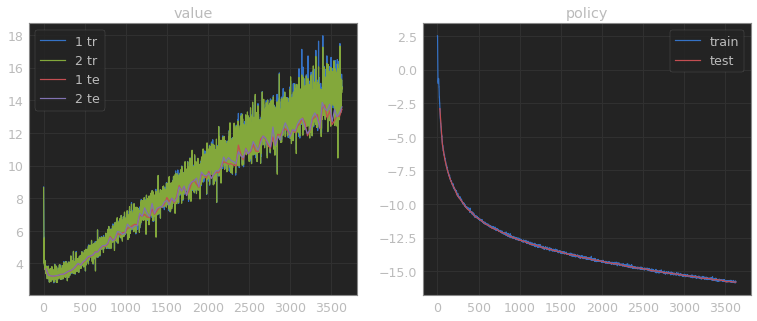

KeyboardInterrupt: 

In [10]:
def prepare_batch(*args):
    args = [torch.tensor(np.array(arg).astype(np.float)).to(cuda).float() for arg in args]
    return args

DEBUG = True

batch = []
plot_every = 30
step = 1
policy_update = 2

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        step += 1
        batch_bar.update(1)
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
        batch = prepare_batch(*batch)
        
        loss = td3_update(step, batch, debug=DEBUG, policy_update=policy_update)
        value1_losses.append(loss[0])
        value2_losses.append(loss[1])
        if step % policy_update == 0:
            policy_losses.append(loss[2])
        else:
            policy_losses.append(policy_losses[-1])
        
        batch = []
        
        # debug plotting
        if step % plot_every == 0:
            plot(value1_losses, value2_losses, policy_losses,)
            
    batch_bar.refresh()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


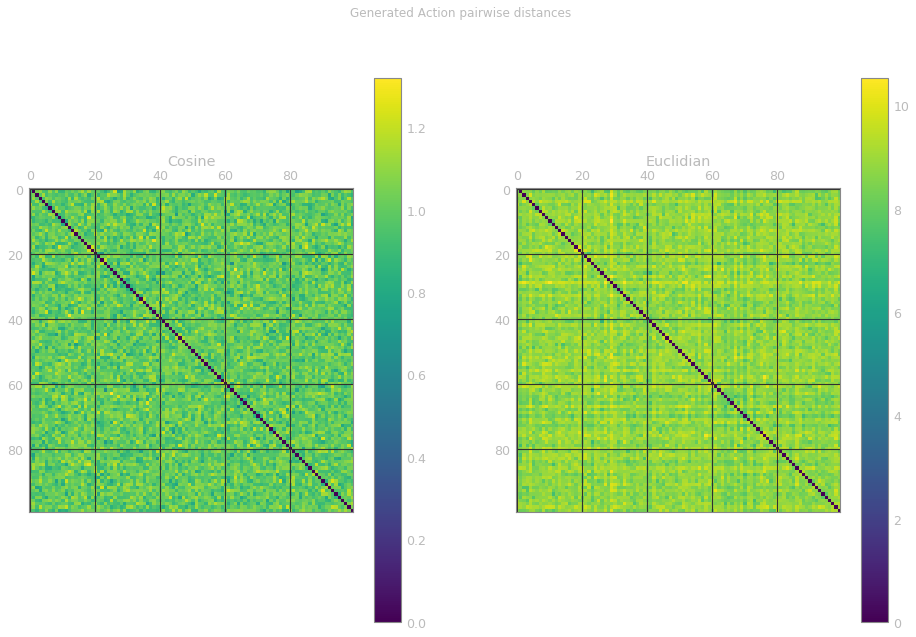

In [11]:
from scipy.spatial import distance

embs = debug_gen_action[:100].detach().cpu().numpy()
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Generated Action pairwise distances')
fig.show()

# Test here

In [12]:
import pickle 
from scipy.spatial import distance
movies = pickle.load(open('../data/infos_pca128.pytorch', 'rb'))
true_actions = np.stack([movies[i] for i in movies])
infos_web = json.load(open('../data/infos.json'))
gen_actions = debug_gen_action
true_actions = np.stack([movies[i] for i in movies])

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


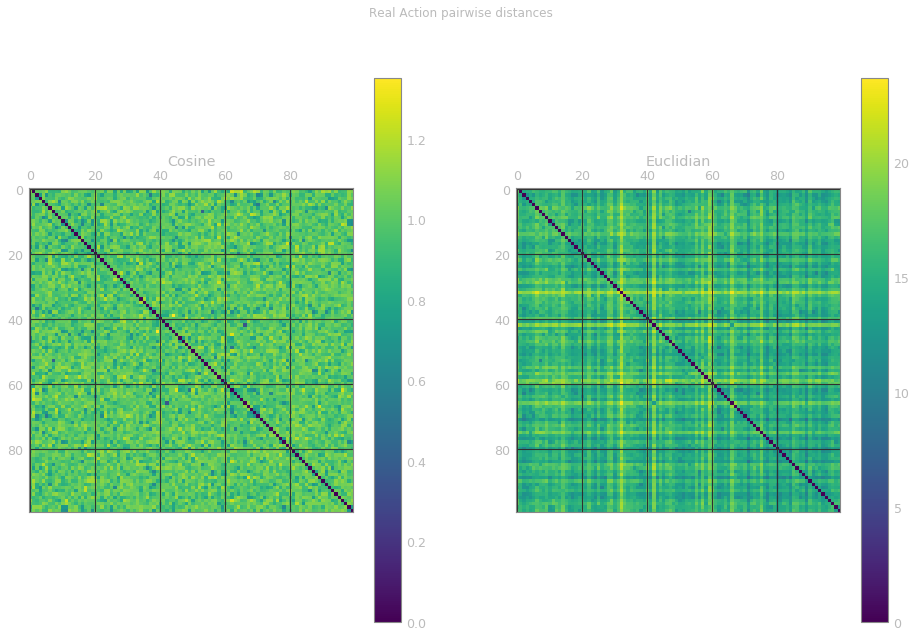

In [13]:
from scipy.spatial import distance

embs = true_actions[:100]
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Real Action pairwise distances')
fig.show()

In [14]:
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()

In [15]:
ad = AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../models/anomaly.pt'))
ad.eval()

AnomalyDetector(
  (ae): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=64, out_features=128, bias=True)
    (10): ReLU()
  )
)

In [16]:
true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


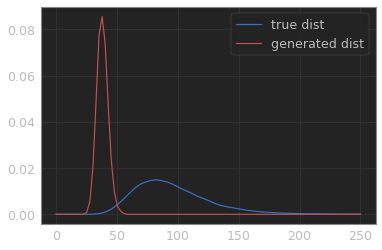

In [17]:
from scipy import stats

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
plt.legend()
plt.show()

## Eucledian Ranking

In [18]:

genres_dict = {'Animation': 16,
 'Comedy': 35,
 'Family': 10751,
 'Adventure': 12,
 'Fantasy': 14,
 'Romance': 10749,
 'Drama': 18,
 'Action': 28,
 'Crime': 80,
 'Thriller': 53,
 'Horror': 27,
 'History': 36,
 'Science Fiction': 878,
 'Mystery': 9648,
 'War': 10752,
 'Music': 10402,
 'Documentary': 99,
 'Western': 37,
 'TV Movie': 10770,
 'Sport': 1,
 'Sci-Fi': 878,
 'Musical': 10402,
 'Short': 2,
 'News': 3,
 'Film-Noir': 4}
genres_dict = {v: k for k, v in genres_dict.items()}

scores = []
gen_action = debug_gen_action[20].detach().cpu().numpy()
for i in movies.keys():
    scores.append([i, distance.euclidean(movies[i], gen_action)])
scores = list(sorted(scores, key = lambda x: x[1]))
scores = scores[:10]
ids = [i[0] for i in scores]
for i in range(10):
    scores[i].extend([infos_web[str(scores[i][0])][key]  for key in ['title',
                            'genres', 'original_language', 'release_year', 'vote_average']])
    scores[i][3] = ' '.join([genres_dict[i] for i in scores[i][3]])
    
indexes = ['id', 'score', 'title', 'genres', 'language', 'year', 'rating']
table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
table = pd.DataFrame(table_dict)
table

,id,score,title,genres,language,year,rating
0,6159,7.786706,All the Real Girls,Drama Romance,en,2003,6.1
1,102167,8.299485,Standing Up,Drama,en,2013,6.8
2,1574,8.306604,Fall,Drama Romance,en,1997,7.0
3,106897,8.323177,Stuck Between Stations,Drama Romance,en,2011,6.2
4,53769,8.424335,In Search of a Midnight Kiss,Comedy Drama Romance,en,2007,6.6
5,69842,8.435999,Good Dick,Comedy Drama Romance,en,2008,6.2
6,111245,8.487502,A Case of You,Comedy Romance,en,2013,5.5
7,101592,8.494255,A Bird of the Air,Drama Romance,en,2011,6.0
8,1186,8.499474,"sex, lies, and videotape",Drama,en,1989,6.9
9,80954,8.565987,Merrily We Live,Comedy Romance,en,1938,7.2


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


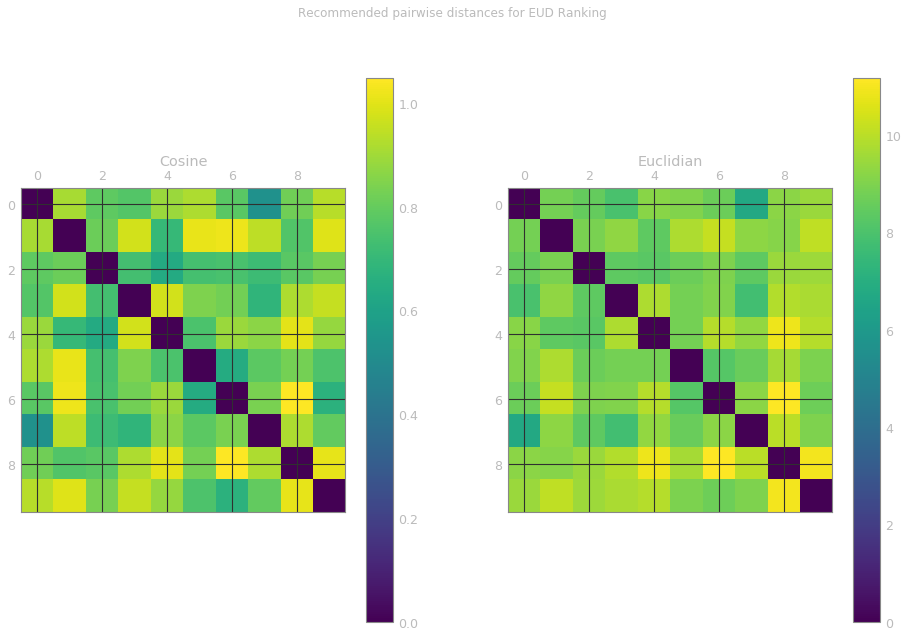

In [19]:
embs = np.stack([movies[i].numpy() for i in ids])
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Recommended pairwise distances for EUD Ranking')
fig.show()

## Cosine Ranking

In [92]:
gen_action = debug_gen_action[20].detach().cpu().numpy()
scores = []
for i in movies.keys():
    scores.append([i, distance.cosine(movies[i], gen_action)])
scores = list(sorted(scores, key = lambda x: x[1]))
scores = scores[:10]
ids = [i[0] for i in scores]
for i in range(10):
    scores[i].extend([infos_web[str(scores[i][0])][key]  for key in ['title',
                            'genres', 'original_language', 'release_year', 'vote_average']])
    scores[i][3] = ' '.join([genres_dict[i] for i in scores[i][3]])
    
indexes = ['id', 'score', 'title', 'genres', 'language', 'year', 'rating']
table_dict = dict([(key,[i[idx] for i in scores]) for idx, key in enumerate(indexes)])
table = pd.DataFrame(table_dict)
table

,id,score,title,genres,language,year,rating
0,117136,0.686045,One Chance,Drama Comedy Musical,en,2013,6.6
1,95058,0.686294,Cosmopolis,Drama,en,2012,5.3
2,117710,0.694047,Murder on the Orient Express,Crime Drama Thriller,en,2001,5.6
3,4864,0.694600,Titanica,Documentary,en,1995,6.0
4,34016,0.710768,My Friends,Comedy,it,1975,8.3
5,7159,0.712431,Two Men Went To War,Comedy Drama War,en,2002,4.8
6,65025,0.715296,Double Dynamite,Comedy Musical,en,1951,5.9
7,8154,0.715678,La Dolce Vita,Comedy Drama,it,1960,8.1
8,2172,0.719788,Strike!,Comedy,en,1998,6.3
9,113703,0.721333,Welcome to New York,Drama,en,2014,5.3


/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


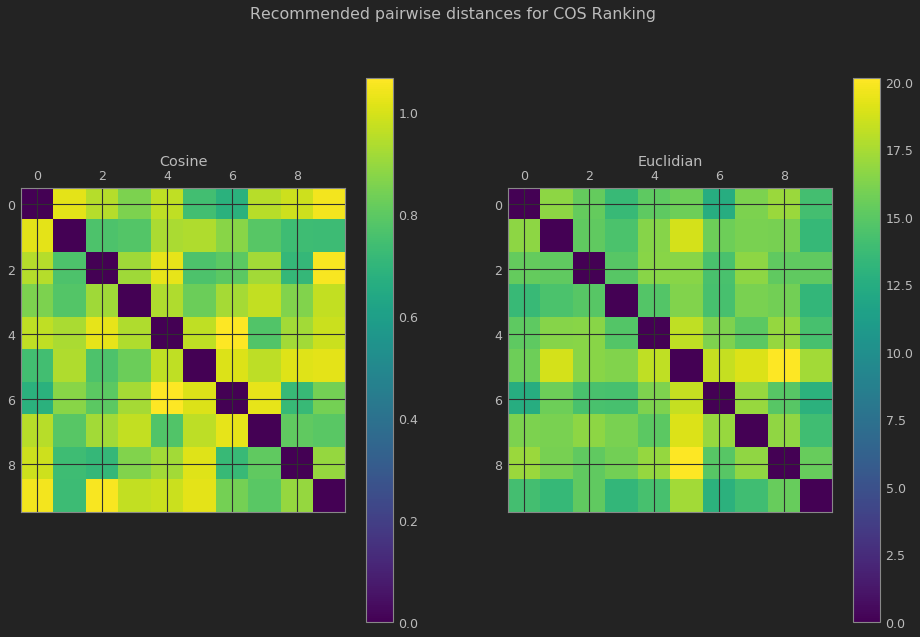

In [93]:
embs = np.stack([movies[i].numpy() for i in ids])
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')
fig.suptitle('Recommended pairwise distances for COS Ranking')
fig.show()